In [135]:
import joblib
import seaborn as sns; sns.set()


from sklearn.metrics import classification_report

In [231]:
%matplotlib inline

In [232]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [233]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
from src.data_utils import import_data
from src.plot_utils import classification_report_image, perform_eda, plot_performance_curves, plot_feature_importance
from src.feature_engineering_utils import add_churn_column, encoder_helper, prepare_for_modeling
from src.training import train_models

In [258]:
with open("./data/bank_data.csv", "r") as file_obj:
    df = import_data(file_obj)

In [259]:
df.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000


In [260]:
df.shape

(10127, 21)

In [261]:
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [262]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [263]:
cat_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'                
]

quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

In [264]:
df = add_churn_column(df)

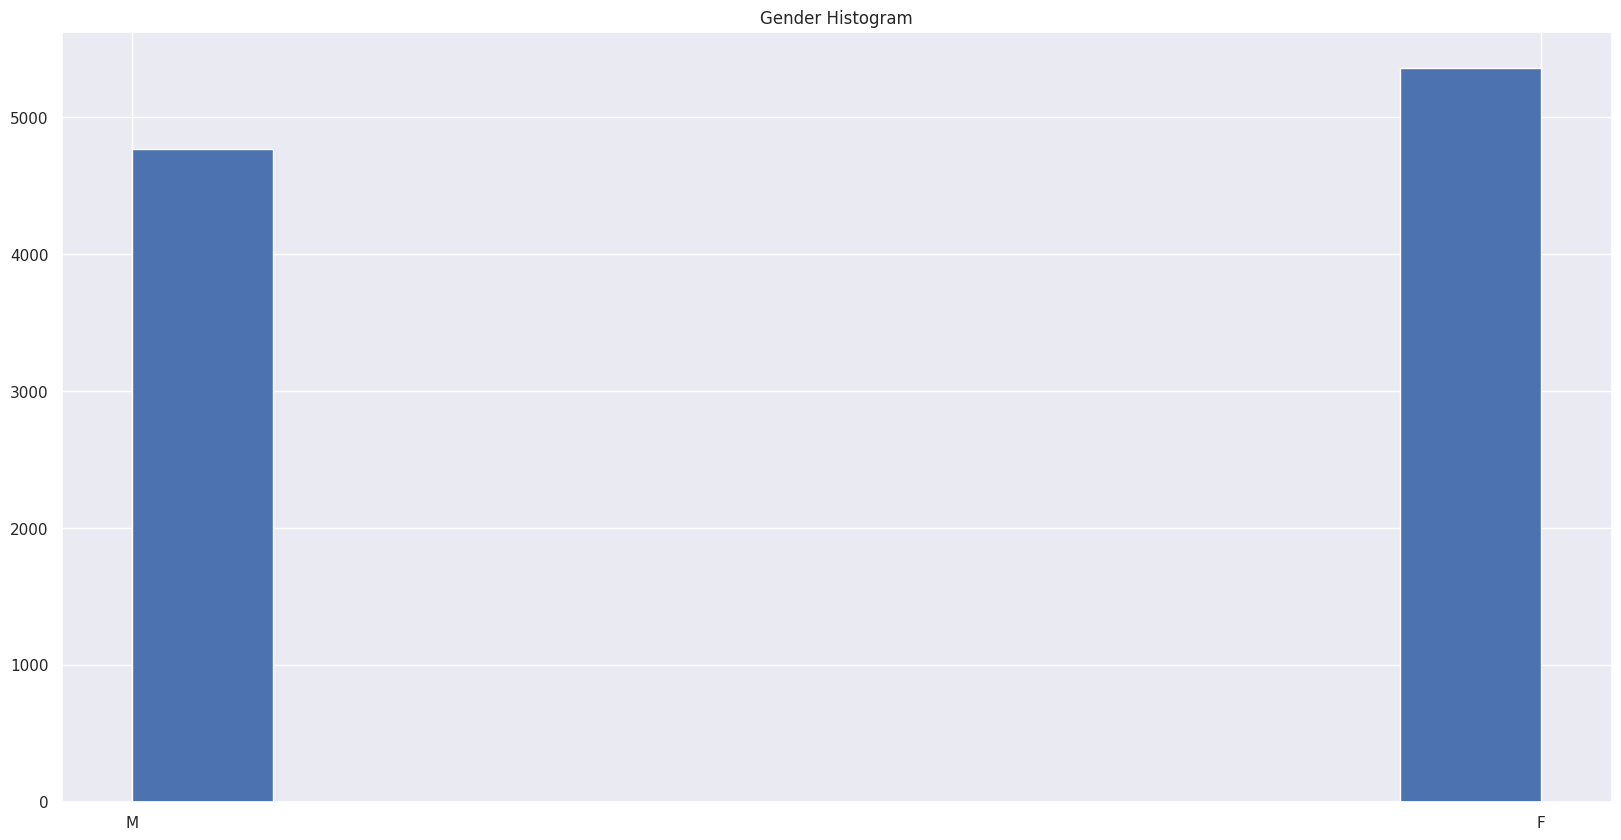

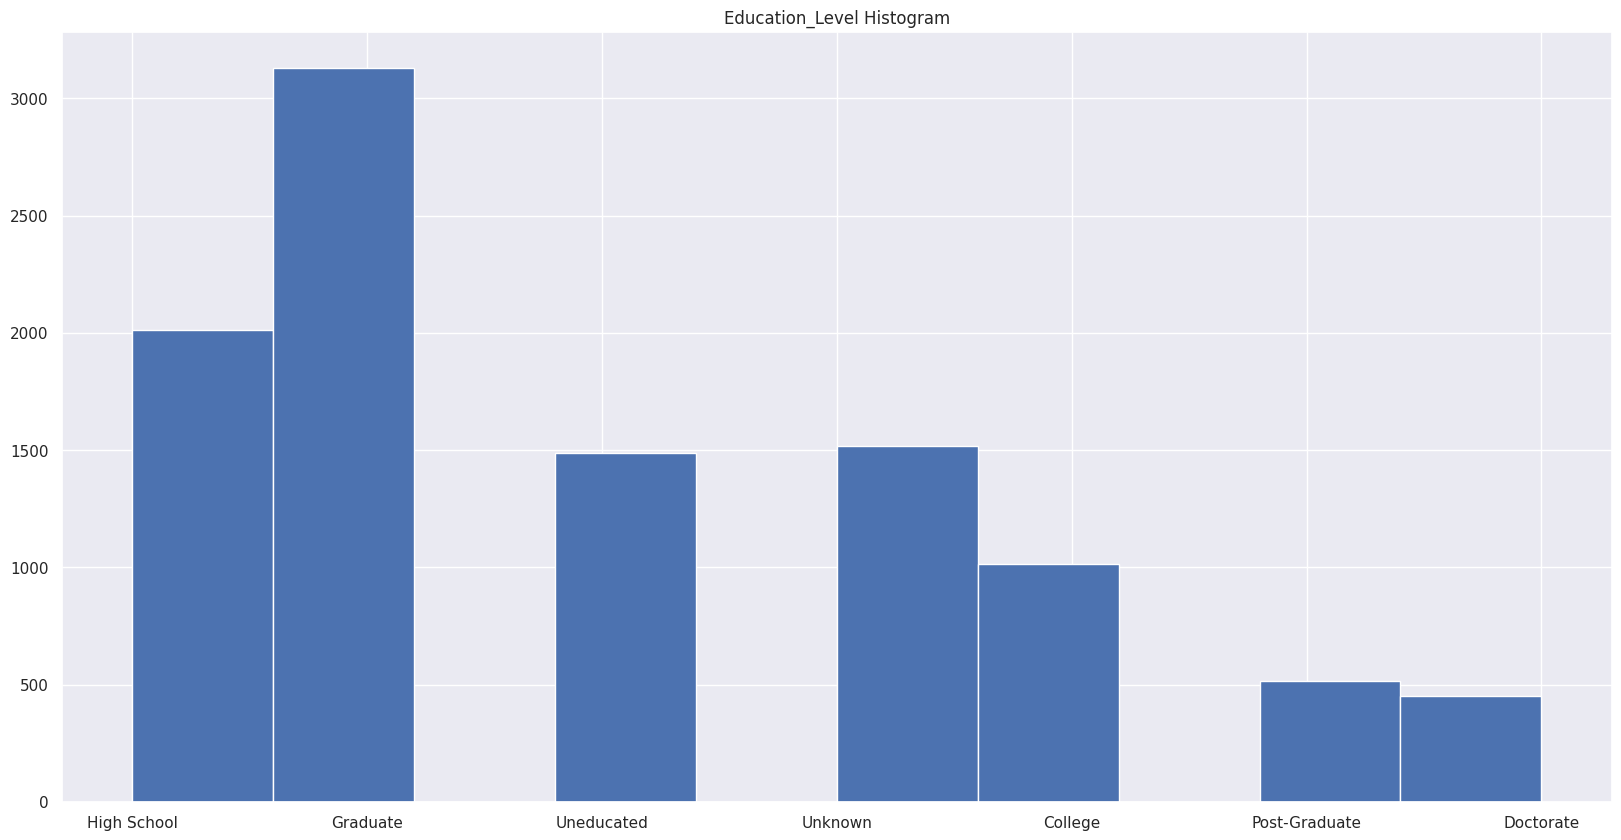

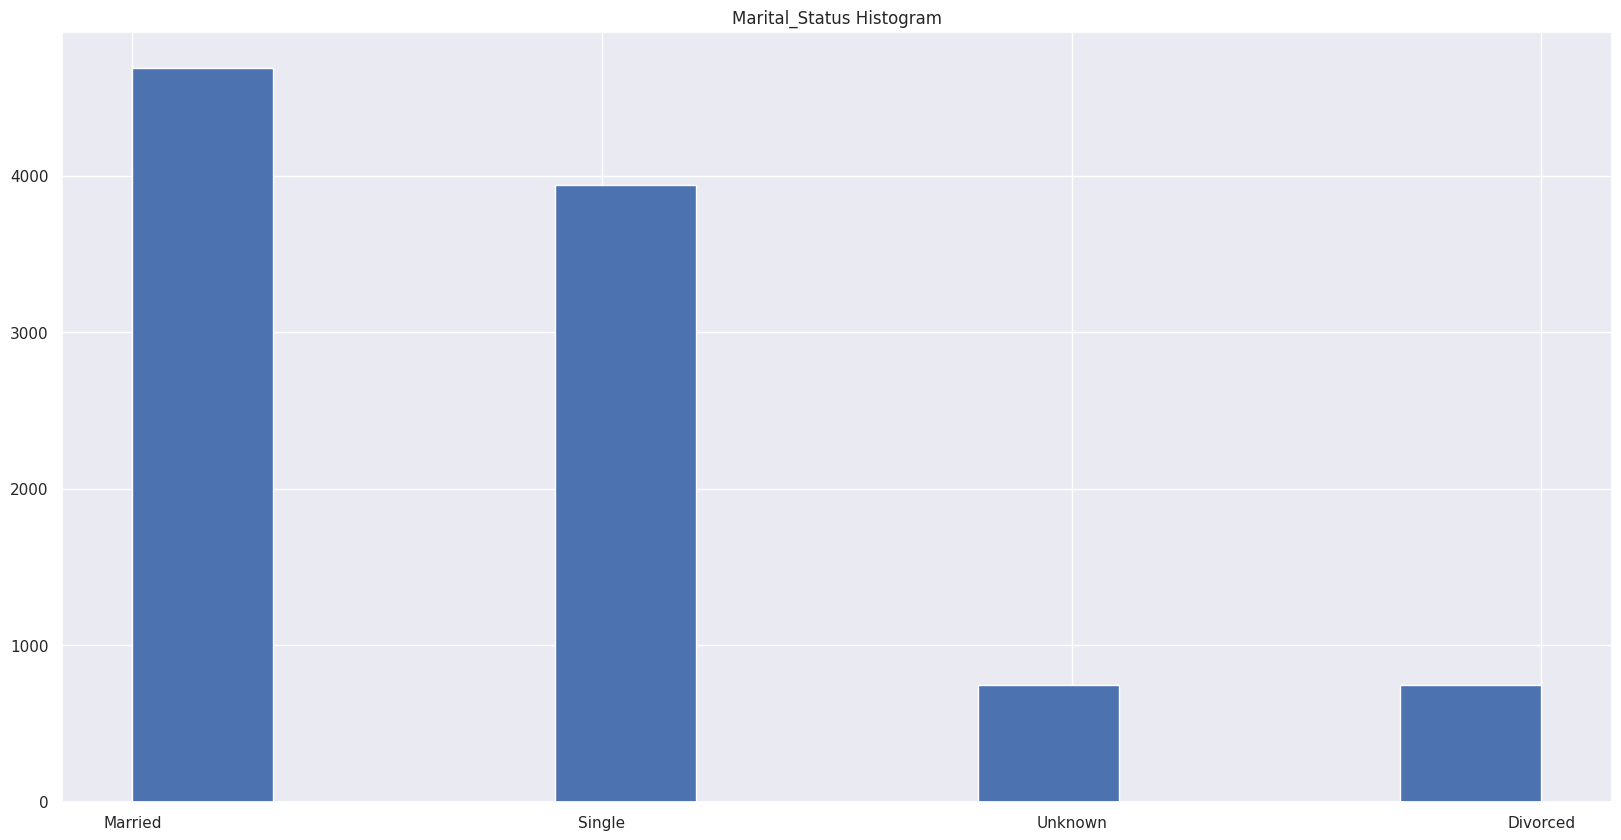

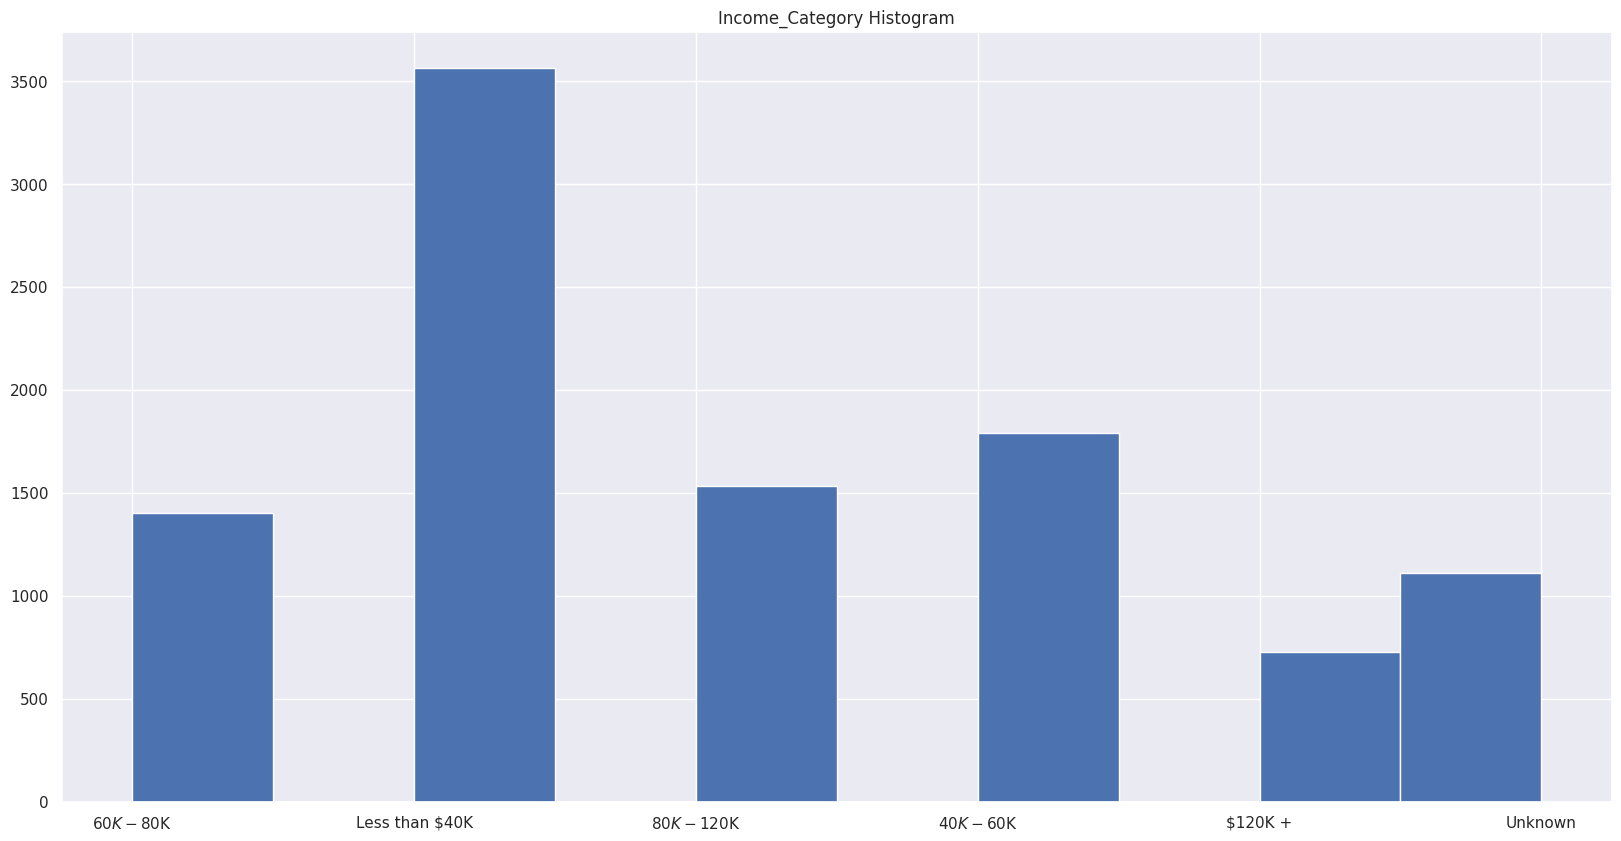

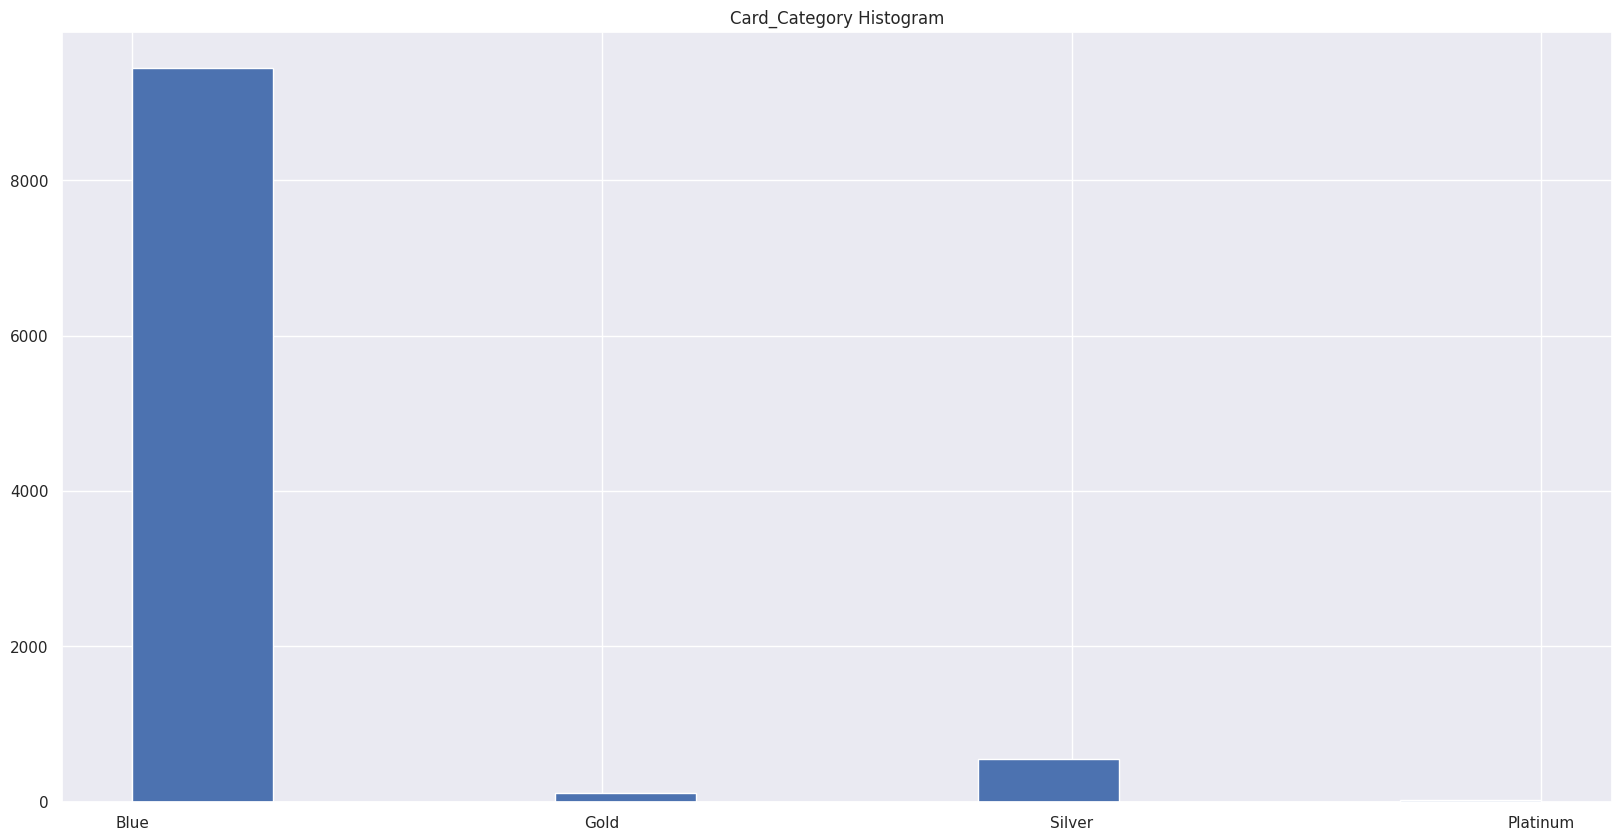

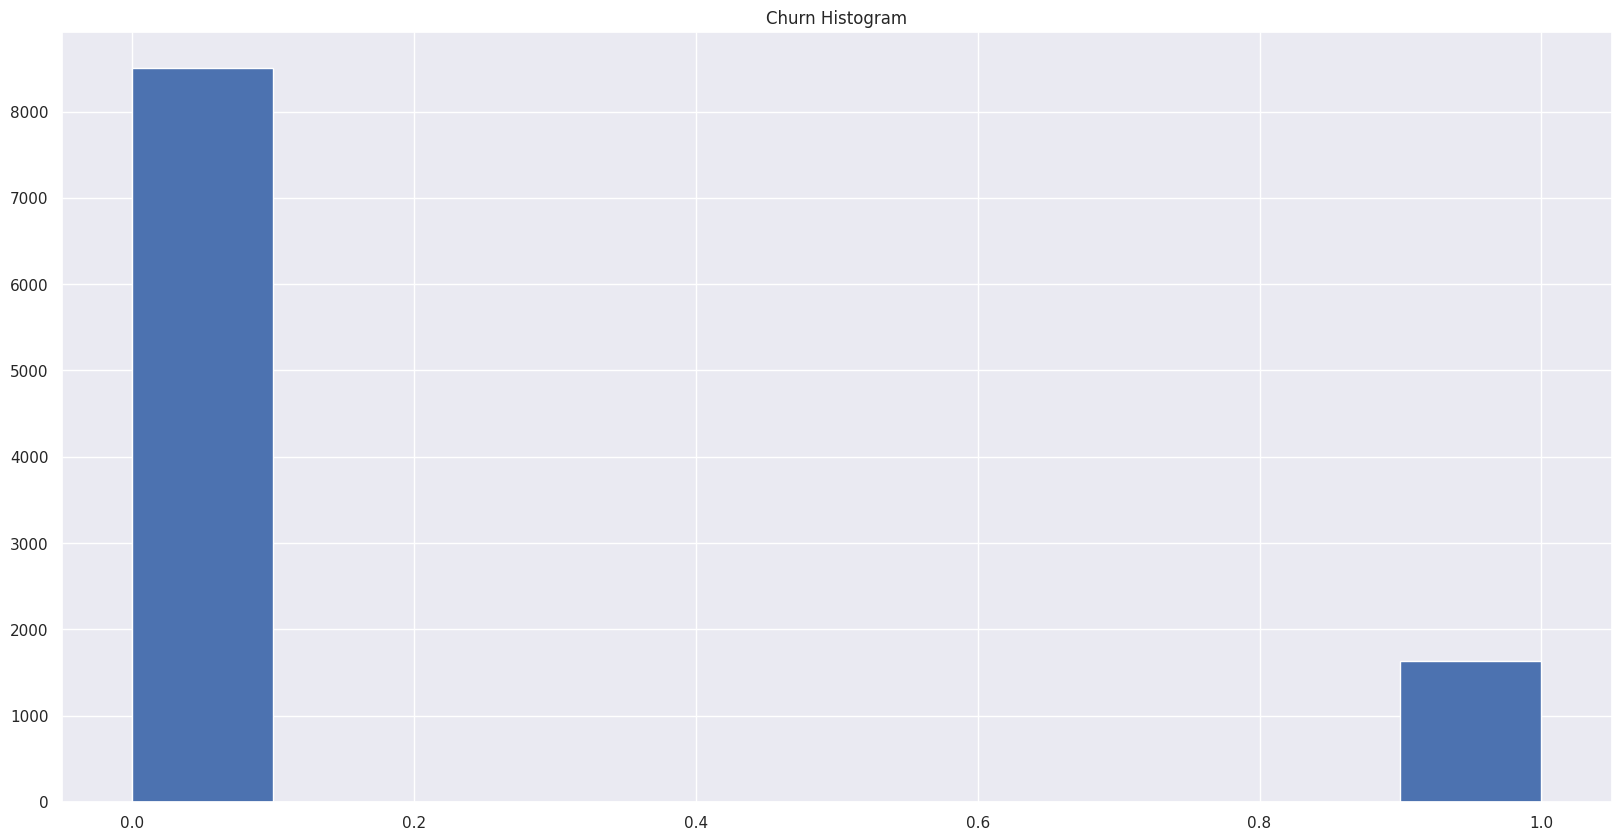

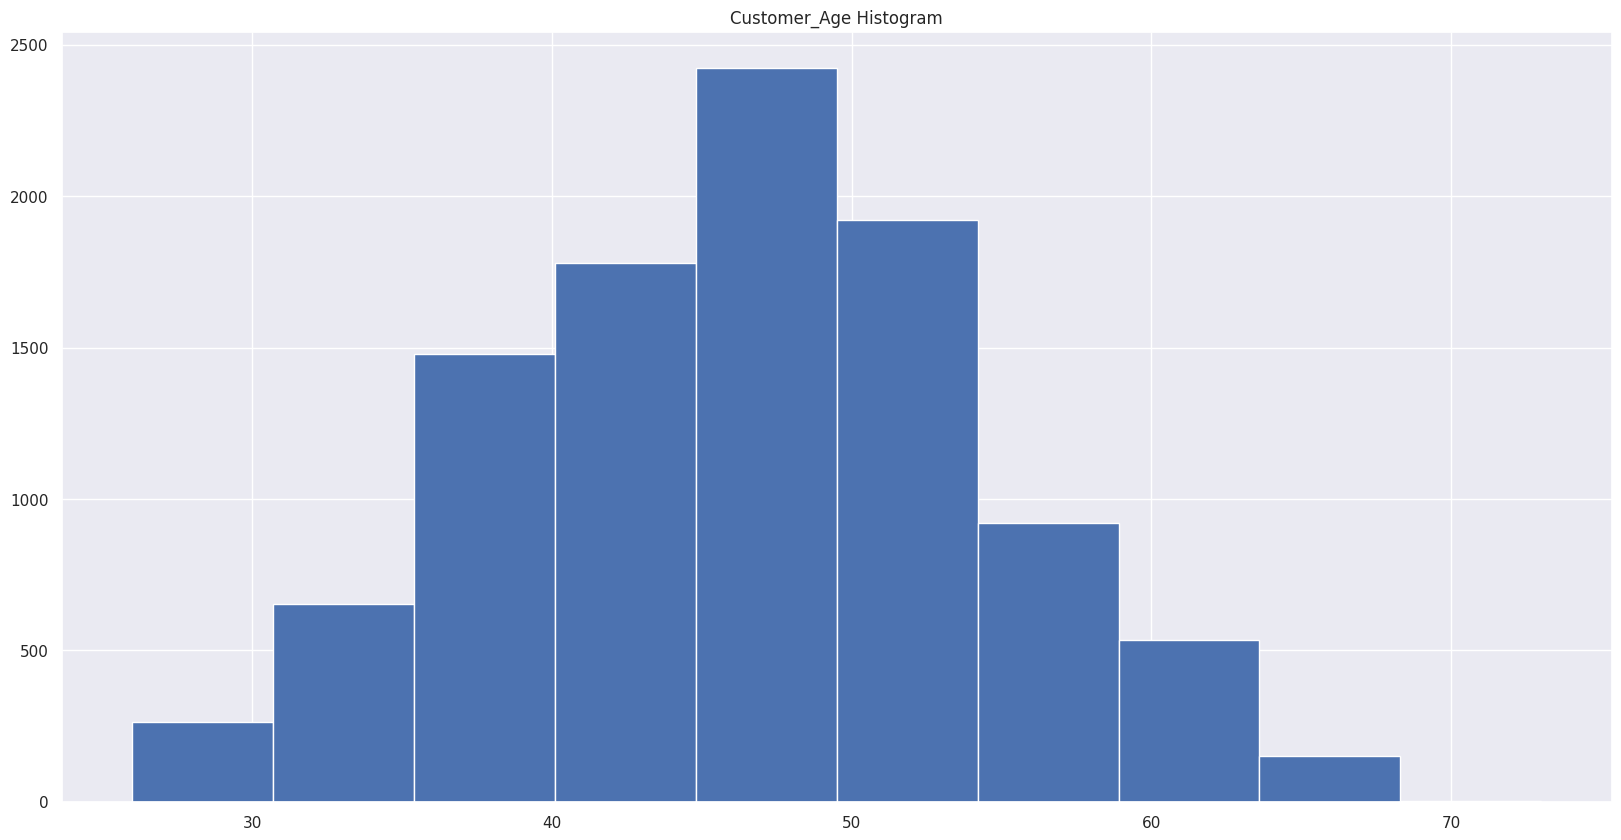

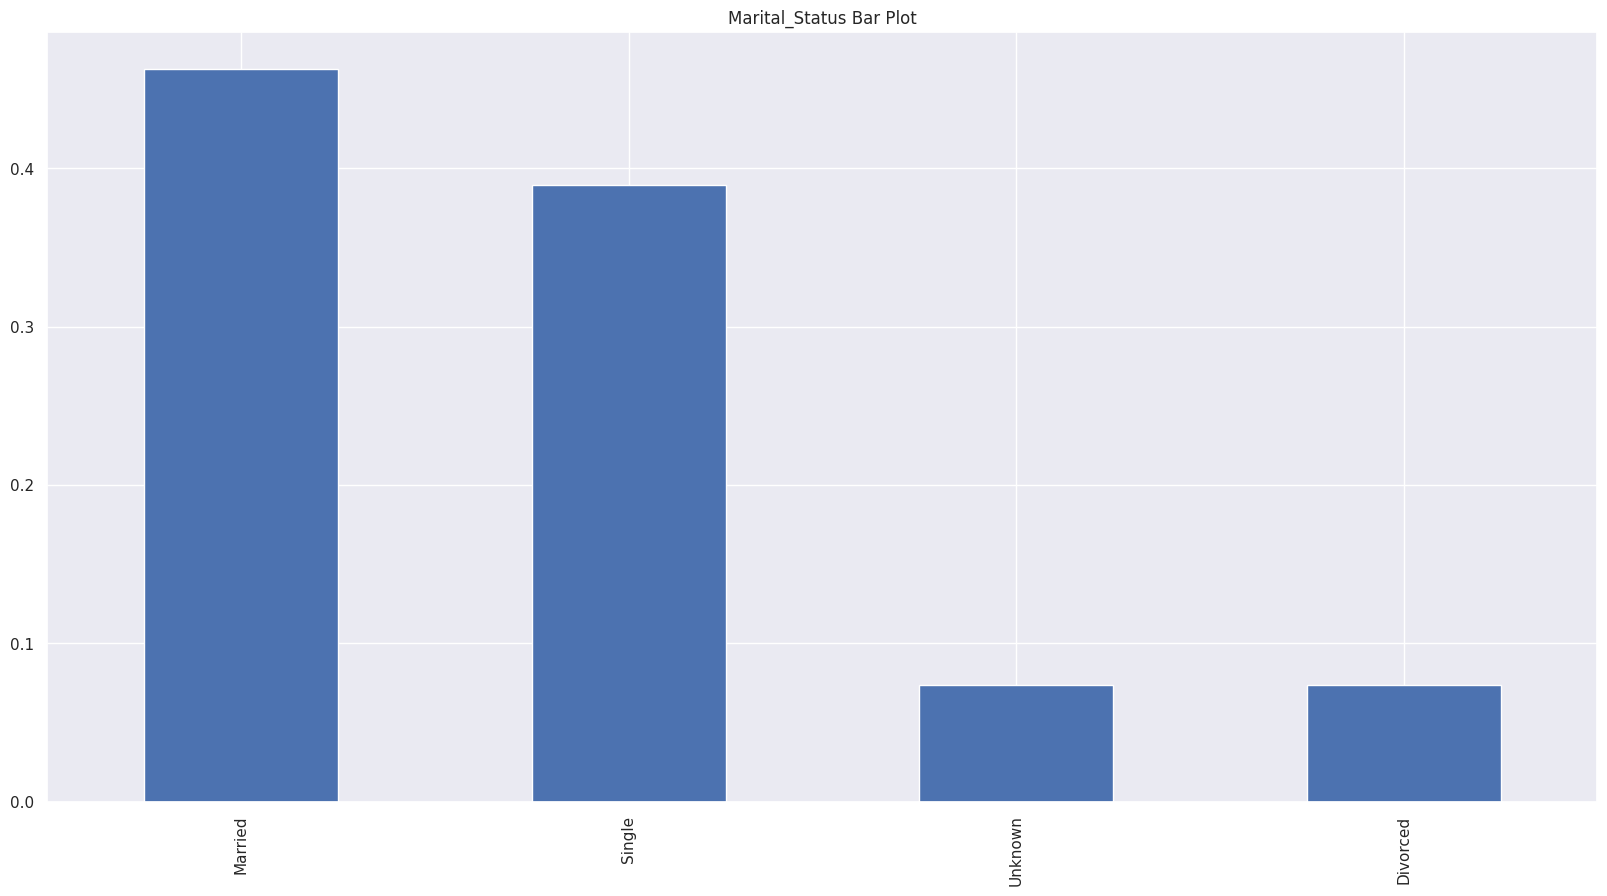

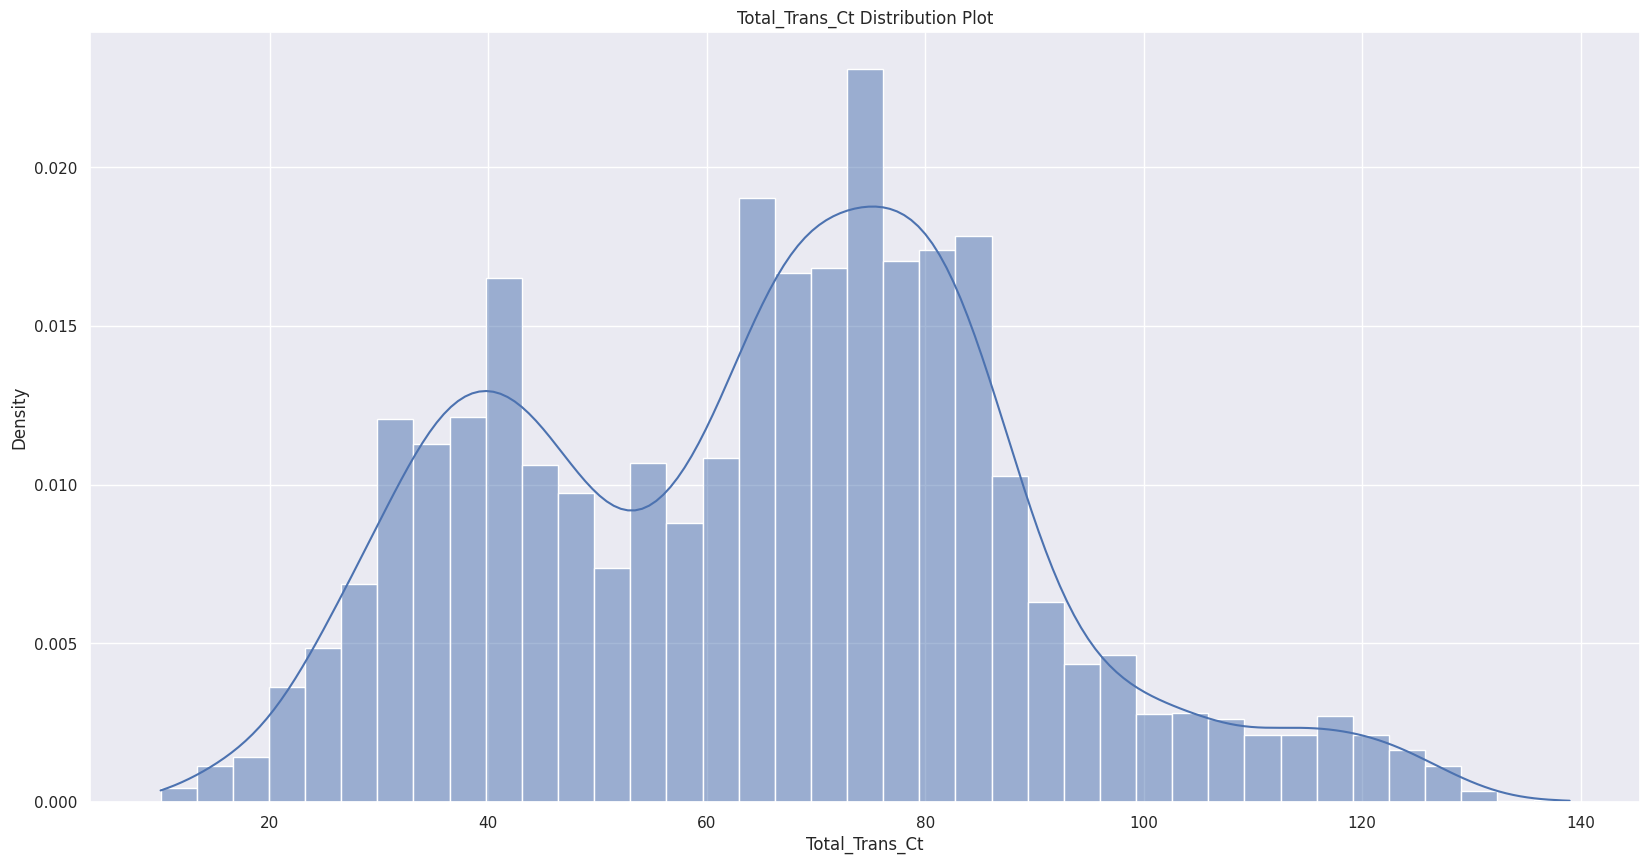

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


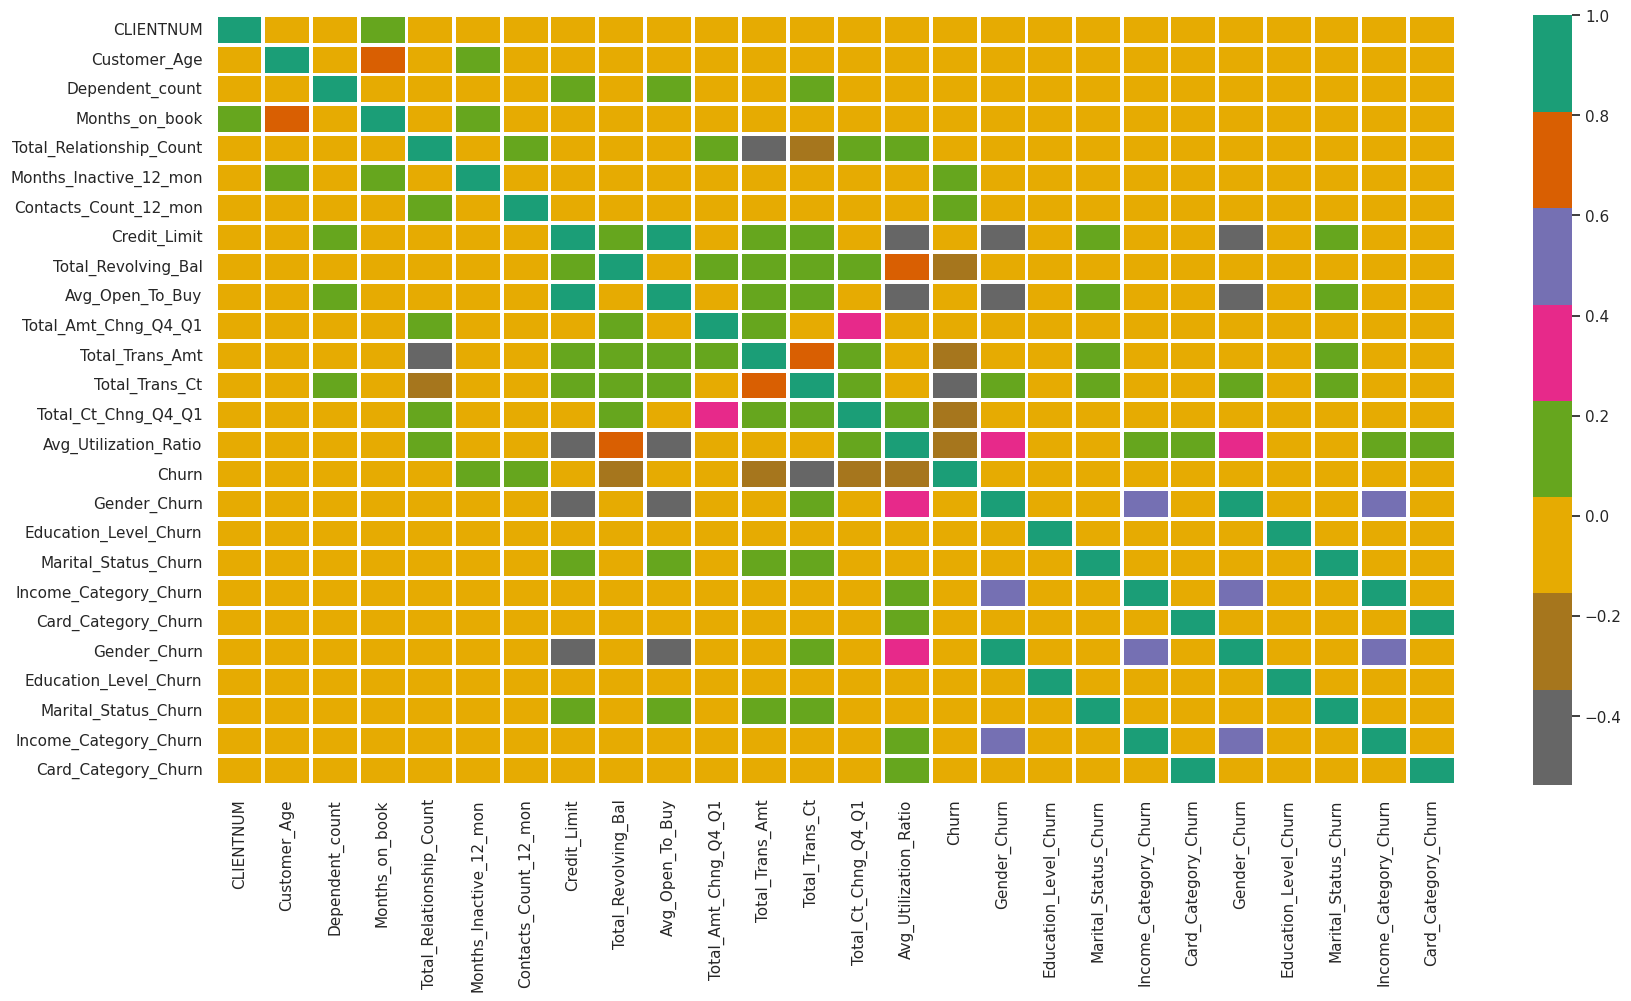

In [271]:
perform_eda(
    df, 
    cat_columns + ['Churn', 'Customer_Age'], 
    ['Marital_Status'], 
    ['Total_Trans_Ct'], 
    './reports/eda/'
    )

In [270]:
import logging
logging.getLoggerClass().root.handlers[0].baseFilename

'/home/adam/learning/udacity/udacity_ml_devops_engineer/project_1_predict_customer_churn_with_clean_code/logs/feature_engineering_utils.log'

#### Create mean churn features grouped by each categorical column

In [267]:
df = encoder_helper(df, cat_columns, 'Churn')

#### Prepare for modeling by dropping redundant columns and splitting the data set 

In [153]:
feature_cols =  ['Customer_Age', 'Dependent_count', 'Months_on_book',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
             'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
             'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
             'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
             'Income_Category_Churn', 'Card_Category_Churn']
target_column = 'Churn'

In [167]:
X_train, X_test, y_train, y_test = prepare_for_modeling(df, feature_cols, target_column, test_size=0.3)

In [168]:
X_train.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
415,49,2,38,3,2,0,8077.0,1965,6112.0,0.637,1329,26,0.444,0.243,0.146152,0.178295,0.151269,0.134807,0.160979
3749,61,0,51,4,2,2,8476.0,0,8476.0,0.675,3889,67,0.489,0.000,0.173572,0.152012,0.169414,0.168165,0.160979
9295,27,0,19,1,1,3,34516.0,1131,33385.0,0.715,14716,112,0.750,0.033,0.146152,0.152024,0.172230,0.157655,0.147748
8290,52,1,36,1,1,3,3040.0,2517,523.0,0.774,4608,61,1.033,0.828,0.173572,0.168532,0.151269,0.171862,0.160979
7672,44,3,36,2,3,3,2228.0,0,2228.0,0.686,2523,45,0.607,0.000,0.173572,0.152012,0.169414,0.171862,0.160979


In [169]:
y_train.head()

415     0
3749    0
9295    0
8290    0
7672    1
Name: Churn, dtype: int64

#### Train the models with Random Forest and Logistic Regression

In [170]:
cv_rfc, lrc = train_models(X_train, y_train)

#### Evaluate Models

In [191]:
y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

y_train_preds_lr = lrc.predict(X_train)
y_test_preds_lr = lrc.predict(X_test)

# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

random forest results
test results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2543
           1       0.93      0.80      0.86       496

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

logistic regression results
test results
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2543
           1       0.71      0.45      0.55       496

    accuracy                           0.88      3039
   macro avg       0.81      0.71     

#### Plot Performance Plots

In [182]:
reports_path = './reports/results/'

<Figure size 1500x800 with 0 Axes>

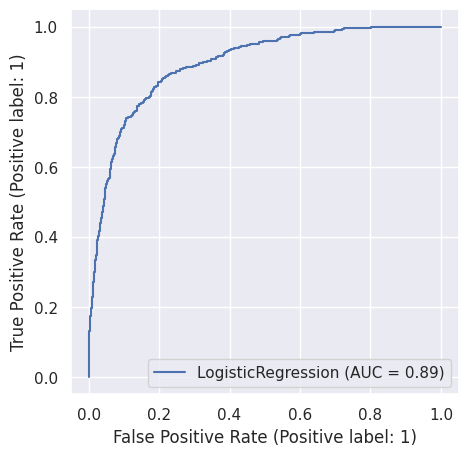

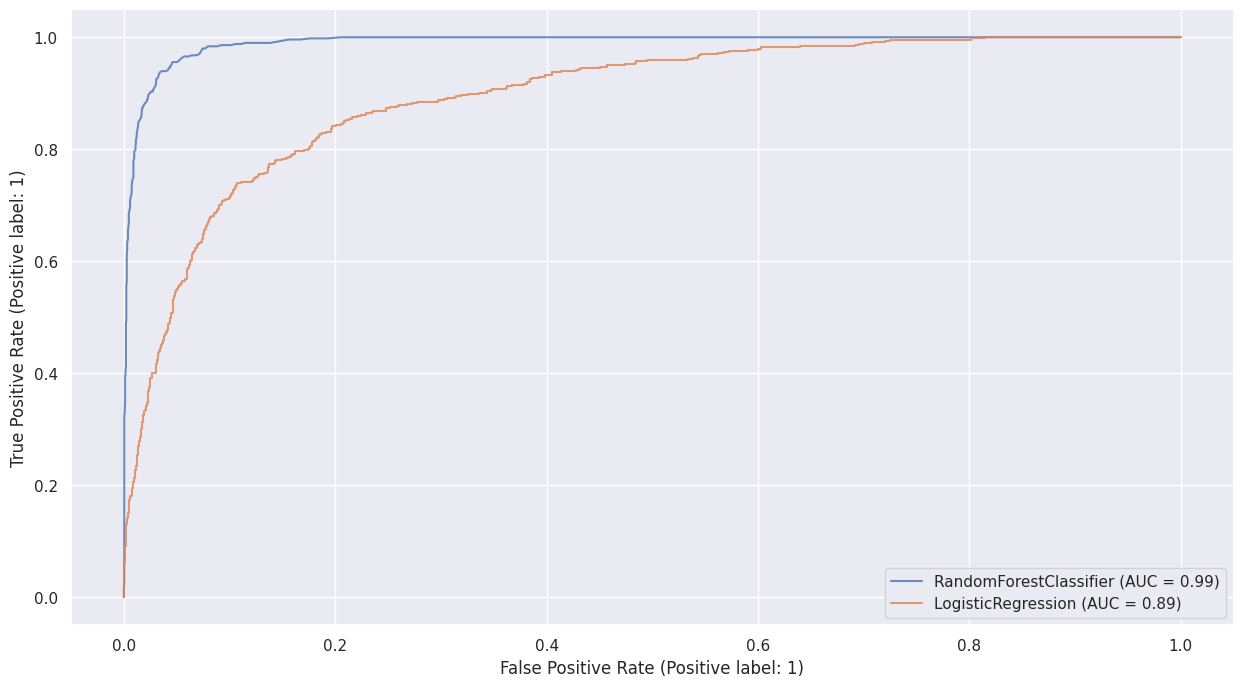

In [199]:
plot_performance_curves(X_test, y_test, cv_rfc, lrc, reports_path)

#### Save and Load Models

In [184]:
# save best model
joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
joblib.dump(lrc, './models/logistic_model.pkl')

['./models/logistic_model.pkl']

In [185]:
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/logistic_model.pkl')

#### Plot Feature Importance Plots

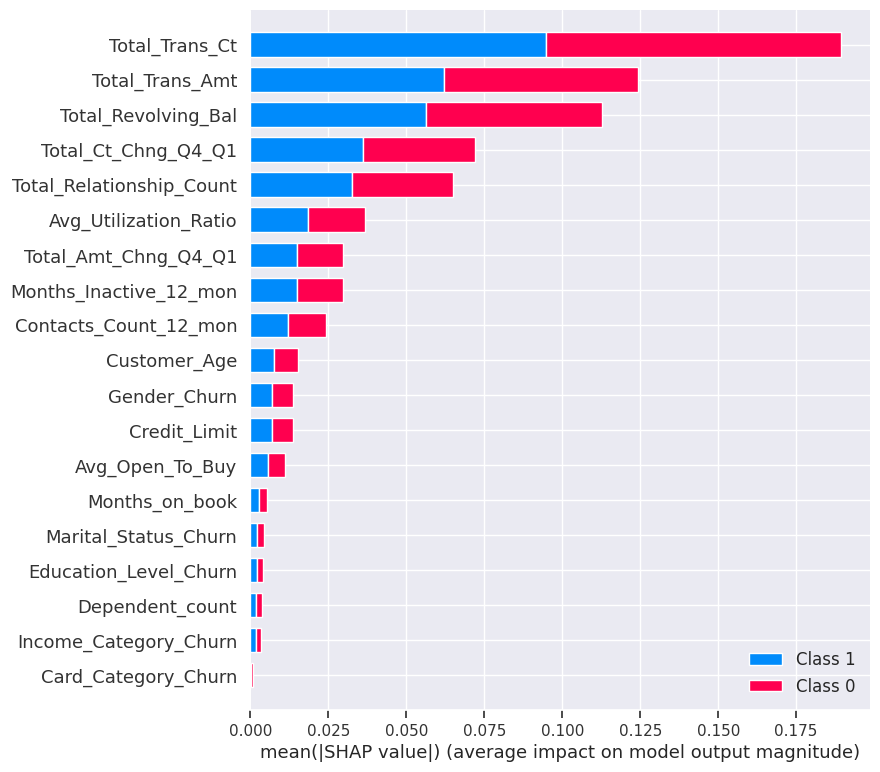

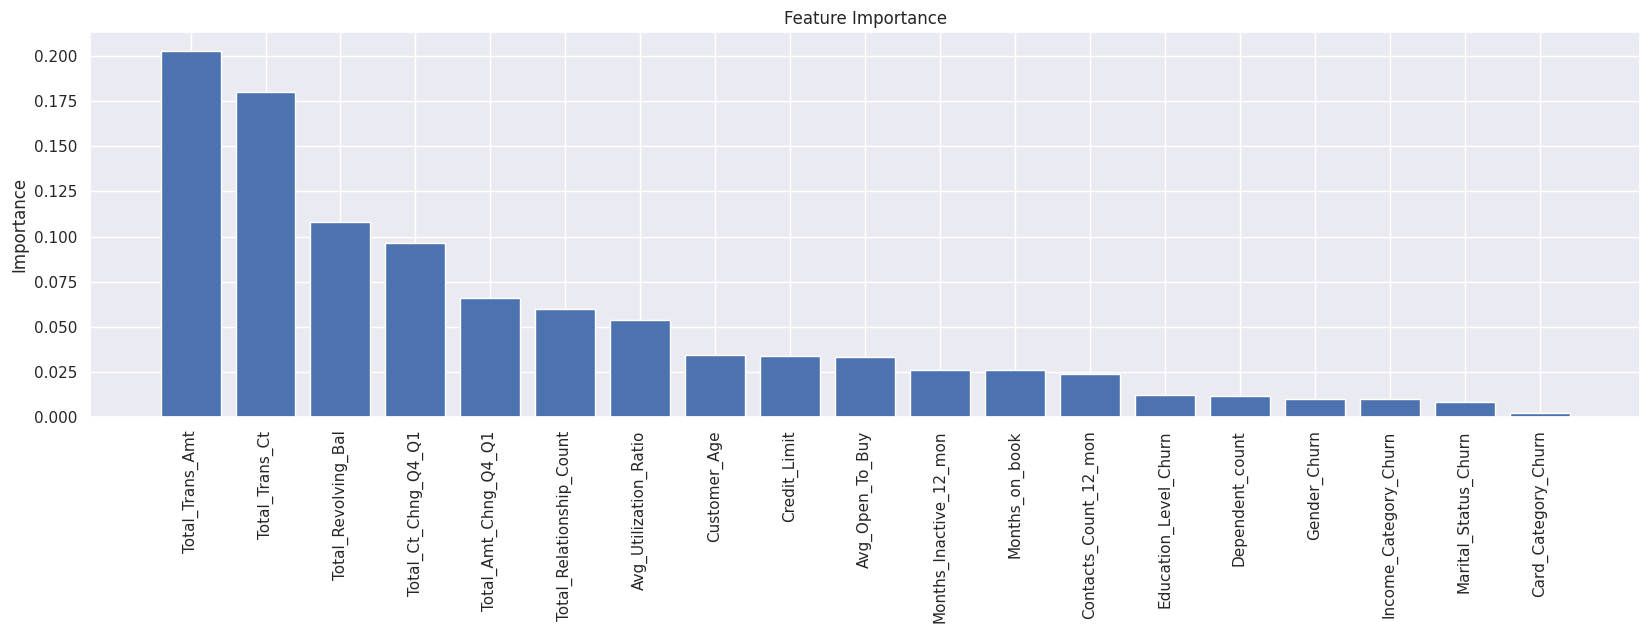

In [208]:
plot_feature_importance(X_test, cv_rfc, reports_path)

In [ ]:
from src.plot_utils import ReportData

report_data = ReportData(y_train, y_test, y_train_preds_rf, y_test_preds_rf, y_train_preds_lr, y_test_preds_lr)

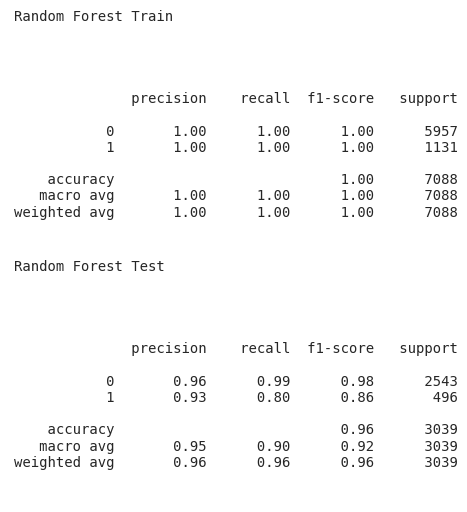

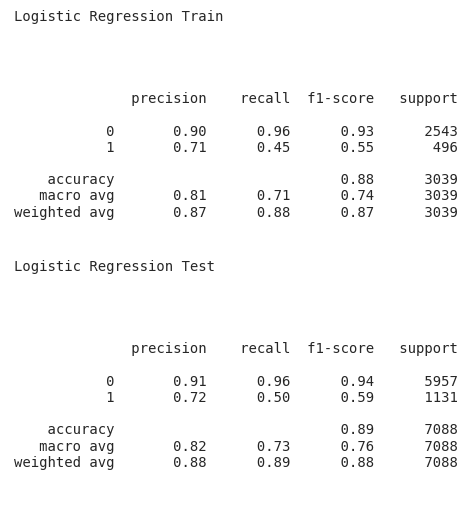

In [210]:
classification_report_image(report_data, reports_path)

In [211]:
import inspect

In [212]:
from src.plot_utils import plot_histogram

In [213]:
print(inspect.signature(plot_histogram))

(df: pandas.core.frame.DataFrame, cat_column: str, file_name: str, *args, **kwargs) -> None
